[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Use Grounded SAM 2 to Auto-Label Images

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

On July 29th, 2024, Meta AI released Segment Anything 2 (SAM 2), a new image and video segmentation foundation model. With SAM 2, you can provide points in an image and generate a segmentation mask for the corresponding point. You can also provide points in a video and generate segmentation masks that are tracked across frames.

SAM 2 follows on from the SAM model released by Meta earlier last year which has been used for tasks such as image segmentation in vision applications and as an image labeling assistant.  According to Meta, SAM 2 is 6x more accurate than the original SAM model at image segmentation tasks.

Here is an example of SAM 2 segmenting parts of an image using points:

![](https://blog.roboflow.com/content/images/2024/07/Untitled-4.png)

In this guide, we will show how to auto-label an image segmentation dataset using Grounded SAM 2, a combination of SAM 2 and a grounding model: Grounding DINO. With this combination, we can provide text prompts instead of coordinate prompts to auto-label objects.

Without further ado, let's get started!

## Install dependencies

First, we need to install the required dependencies for this project:

In [1]:
!pip install git+https://github.com/autodistill/autodistill-grounded-sam-2 rf_groundingdino -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 243.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.6 MB/s eta 0:00:00


## Collect data

For this project, we need a folder of unlabeled images. We will label these images with Grounded SAM 2, then use them to train a model.

For this guide, we will use a dataset of shipping containers. We will use the dataset to train a model that can identify shipping containers.

In [ ]:
!wget https://media.roboflow.com/containers.zip
!unzip containers.zip

## Load Grounded SAM 2

With a dataset ready, we can load Grounded SAM 2.

We need to provide an ontology for Grounded SAM 2. This refers to the objects that we want to identify, and the labels that we want to use in our dataset.

An ontology uses the following structure:

```
{"prompt": "label"}
```

For example, the following ontology will send the prompt "shipping container" to a model and save the results with the label "container":

```
{"shipping container": "container"}
```

In [2]:
from autodistill_grounded_sam_2 import GroundedSAM2

Importing from timm.models.layers is deprecated, please import via timm.layers
Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.


In [12]:
from autodistill.detection import CaptionOntology
from autodistill.utils import plot
import numpy as np
import cv2
import os
import random
import supervision as sv

# define an ontology to map class names to our Grounded SAM 2 prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
base_model = GroundedSAM2(
    ontology=CaptionOntology(
        {
            "marine life fish": "fish . peces. pez . marine animal. acuatic animal . sea snake "
        }
    ),
    model = "Grounding DINO",
    grounding_dino_box_threshold=0.25
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


## Test the model

Now that we have loaded the model, we can test it on images. Let's test on random images in the `containers` directory we downloaded earlier. If you are using your own dataset, replace the value of `IMAGE_DIR` with the folder where your unlabeled images are stored.

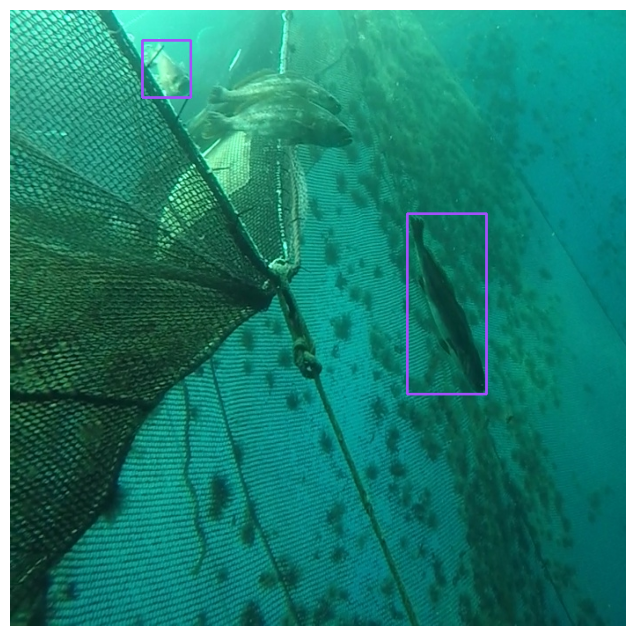

In [22]:
IMAGE_DIR = "/content/peces2"

IMAGE_PATH = os.path.join(IMAGE_DIR, random.choice(os.listdir(IMAGE_DIR)))

results = base_model.predict(IMAGE_PATH).with_nms()
results = results[results.confidence > 0.4
                  ]

image = cv2.imread(IMAGE_PATH)

mask_annotator = sv.BoxAnnotator()

annotated_image = mask_annotator.annotate(
	image.copy(), detections=results
)

sv.plot_image(image=annotated_image, size=(8, 8))

If your prompt does not work well, update your ontology to use a new prompt.

It may take a few tries to find a prompt that works.

Note that Grounding DINO, on which Grounded SAM 2 depends for object identification, cannot identify all objects. If, after experimentation, you cannot get the model to identify objects of interest, this model may not be suited to your task.

## Label the dataset

Once you have found a prompt that works for your dataset, you can label your dataset like so:

In [ ]:
base_model.label(IMAGE_DIR, extension="jpg")

Labeling containers/Tips-and-tricks-on-how-to-park-a-yard-jockey-_mp4-179_jpg.rf.fbf409ad7c9b897f45bec5a2bfeb4099.jpg: 100%|██████████| 156/156 [01:19<00:00,  1.97it/s]
Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


Labeled dataset created - ready for distillation.


With a labeled dataset ready, the next step is to inspect the quality of the labels and train your model. Roboflow has utilities for both of these steps. With Roboflow, you can review and amend annotations, then use your dataset to train a model.

[Create a free Roboflow account](https://roboflow.com), then create a new project in your Roboflow dashboard. Once you have a new project, you can upload your labeled data to the platform with the following code:

In [ ]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

workspace = rf.workspace("capjamesg")
workspace.upload_dataset(
    IMAGE_DIR + "_labeled/",
    "shipping-containers-kktus",
    project_license="MIT",
    project_type="object-detection",
)

Above, replace:

- `WORKSPACE_ID` with your workspace ID. [Learn how to find your workspace ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids)
- `PROJECT_ID` with the name of your project ID. [Learn how to find your project ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids)

Once you have run the code cell above, go back to your Roboflow project. Here, you can inspect the quality of all annotations and make the requisite changes

You can add, adjust, and remove polygons. To learn more about annotating with Roboflow and the features available, refer to the [Roboflow Annotate documentation](https://docs.roboflow.com/annotate/annotation-tools).

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.